# Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm

# General Parameters

In [2]:
S0 = 100         # Initial price of the risky asset
mu = 0.08        # Expected annual return (drift) of the risky asset
sigma = 0.15     # Annual volatility of the risky asset
T = 1.0          # Total investment horizon in years
dt = 1/252       # Time step in years (assuming 252 trading days per year)

# Simulation of a geometric Brownian motion process (GBM)

In [3]:
def simulate_gbm(S0, mu, sigma, T, dt):
    N = int(T / dt)
    t = np.linspace(0, T, N + 1)
    S = np.zeros(N + 1)
    S[0] = S0
    for i in range(N):
        z = np.random.normal()  # white noise
        S[i+1] = S[i] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return t, S

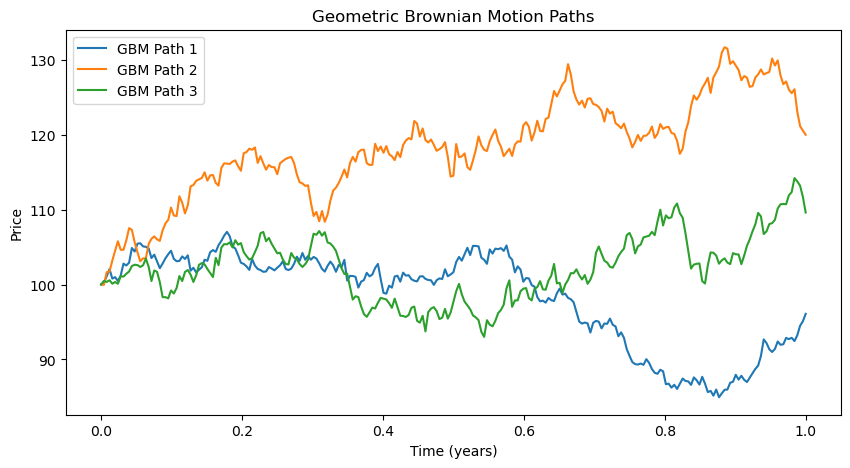

In [9]:
np.random.seed(49)

t, S = simulate_gbm(S0, mu, sigma, T, dt)

plt.figure(figsize=(10, 5))

for i in range(3):
    t, S = simulate_gbm(S0, mu, sigma, T, dt)
    plt.plot(t, S, label=f"GBM Path {i+1}")

plt.title("Geometric Brownian Motion Paths")
plt.xlabel("Time (years)")
plt.ylabel("Price")
plt.legend()
plt.show()

# Simulation of a process with jumps (Merton Jump Diffusion)

In [11]:
def simulate_jump_diffusion(S0, mu, sigma, T, dt, lamb, jump_mu, jump_sigma):
    N = int(T / dt)
    t = np.linspace(0, T, N + 1)
    S = np.zeros(N + 1)
    S[0] = S0
    for i in range(N):
        z = np.random.normal()  # Diffusion component
        n_jumps = np.random.poisson(lamb * dt)
        J = 1.0
        if n_jumps > 0:
            for _ in range(n_jumps):
                J *= np.exp(np.random.normal(jump_mu, jump_sigma))
        drift_adjustment = mu - lamb * (np.exp(jump_mu + 0.5 * jump_sigma**2) - 1)
        S[i+1] = S[i] * np.exp((drift_adjustment - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z) * J
    return t, S

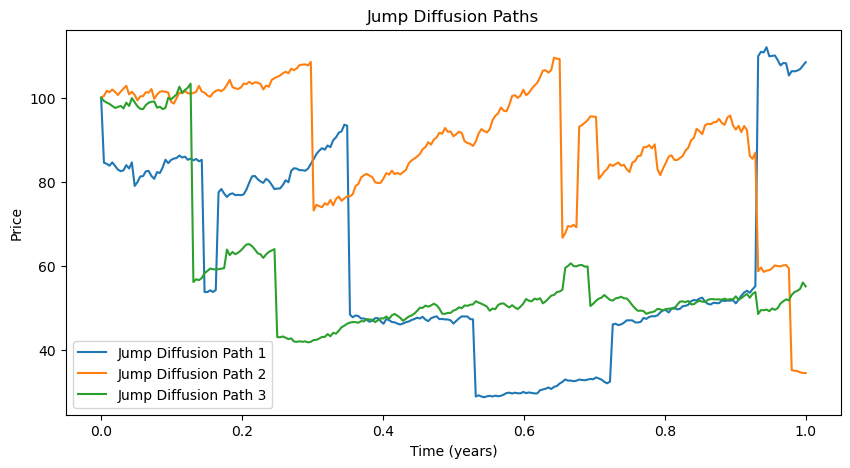

In [13]:
np.random.seed(90)

lamb = 10         # Average jump intensity per year
jump_mu = -0.1    # Mean jump size (log)
jump_sigma = 0.3  # Jump volatility

plt.figure(figsize=(10, 5))

for i in range(3):
    t, S = simulate_jump_diffusion(S0, mu, sigma, T, dt, lamb, jump_mu, jump_sigma)
    plt.plot(t, S, label=f"Jump Diffusion Path {i+1}")

plt.title("Jump Diffusion Paths")
plt.xlabel("Time (years)")
plt.ylabel("Price")
plt.legend()
plt.show()

# Investment strategies

In [15]:
S0 = 100                      # Initial price of the risky asset
mu = 0.08                     # Expected annual return (drift) of the risky asset
sigma = 0.15                  # Annual volatility of the risky asset
T = 1.0                       # Total investment horizon in years
dt = 1/252                    # Time step in years (assuming 252 trading days per year)
initial_portfolio = 1000      # Initial capital
r = 0.02                       # Risk-free rate (2% per annum)

## All in the risk free

In [17]:
def simulate_zero_coupon_portfolio(initial_portfolio: float, r: float, T: float, dt: float):
    t = np.arange(0, T + dt, dt)
    portfolio = initial_portfolio * np.exp(r * t)
    return t, portfolio

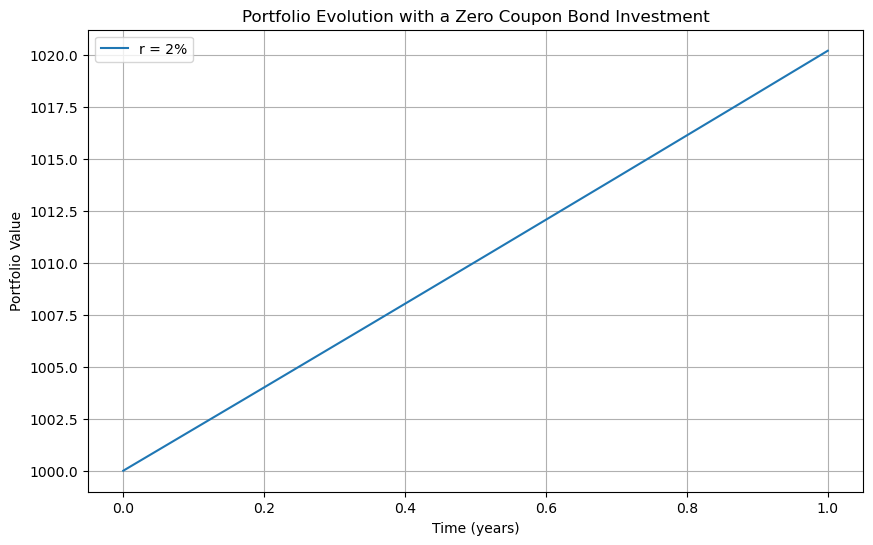

In [19]:
t, portfolio = simulate_zero_coupon_portfolio(initial_portfolio, r, T, dt)
    
plt.figure(figsize=(10, 6))
plt.plot(t, portfolio, label="r = 2%")
plt.title("Portfolio Evolution with a Zero Coupon Bond Investment")
plt.xlabel("Time (years)")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.show()

## Constant proportion portfolio insurance (CPPI) with no multiplier

In [21]:
def simulate_cppi_naive(risky_prices, riskfree_rate, dt, initial_portfolio, T, N):
    n = len(risky_prices)
    portfolio = np.zeros(n)  
    portfolio[0] = initial_portfolio  

    for i in range(n - 1):
        t = i * dt
        floor = N * np.exp(-riskfree_rate * (T - t))
        
        # Dynamically calculate the number of risky asset shares:
        if portfolio[i] <= floor:
            k = 0
        else:
            k = (portfolio[i] - floor) / risky_prices[i]
        
        # The risk-free component is the remainder of the portfolio
        riskfree_part = portfolio[i] - k * risky_prices[i]
        riskfree_growth = np.exp(riskfree_rate * dt)
        
        # Update the portfolio value for the next time step:
        portfolio[i+1] = riskfree_part * riskfree_growth + k * risky_prices[i+1]
    
    return portfolio

### Parameters

In [23]:
n = 10                # Number of simulations
N_conservative = 900  # e.g., guarantee 900 (more funds allocated to the risk-free asset)
N_aggressive   = 700  # e.g., guarantee 700 (more funds allocated to the risky asset)

### GBM

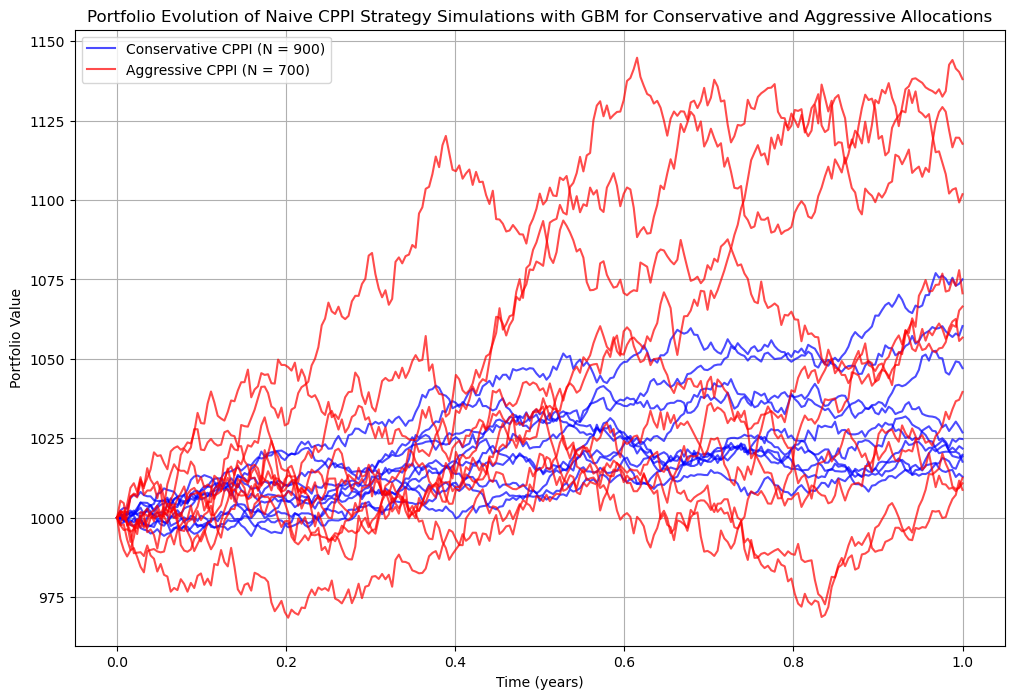

In [25]:
np.random.seed(90)

plt.figure(figsize=(12, 8))

for i in range(n):
    t, risky_prices = simulate_gbm(S0, mu, sigma, T, dt)
    portfolio = simulate_cppi_naive(risky_prices, r, dt, initial_portfolio, T, N_conservative)
    if i == 0:
        plt.plot(t, portfolio, color='blue', alpha=0.7, label="Conservative CPPI (N = 900)")
    else:
        plt.plot(t, portfolio, color='blue', alpha=0.7)

for i in range(n):
    t, risky_prices = simulate_gbm(S0, mu, sigma, T, dt)
    portfolio = simulate_cppi_naive(risky_prices, r, dt, initial_portfolio, T, N_aggressive)
    if i == 0:
        plt.plot(t, portfolio, color='red', alpha=0.7, label="Aggressive CPPI (N = 700)")
    else:
        plt.plot(t, portfolio, color='red', alpha=0.7)

plt.xlabel("Time (years)")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Evolution of Naive CPPI Strategy Simulations with GBM for Conservative and Aggressive Allocations")
plt.legend()
plt.grid(True)
plt.show()

## Jump Process

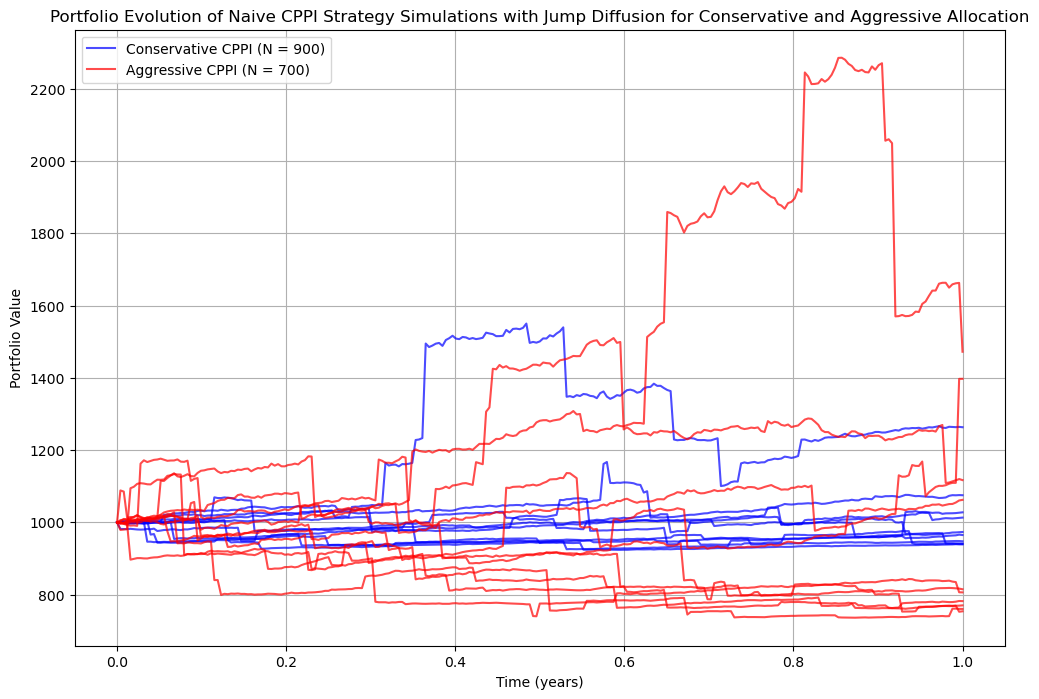

In [27]:
np.random.seed(90)

plt.figure(figsize=(12, 8))

for i in range(n):
    t, risky_prices = simulate_jump_diffusion(S0, mu, sigma, T, dt, lamb, jump_mu, jump_sigma)
    portfolio = simulate_cppi_naive(risky_prices, r, dt, initial_portfolio, T, N_conservative)
    if i == 0:
        plt.plot(t, portfolio, color='blue', alpha=0.7, label="Conservative CPPI (N = 900)")
    else:
        plt.plot(t, portfolio, color='blue', alpha=0.7)

for i in range(n):
    t, risky_prices = simulate_jump_diffusion(S0, mu, sigma, T, dt, lamb, jump_mu, jump_sigma)
    portfolio = simulate_cppi_naive(risky_prices, r, dt, initial_portfolio, T, N_aggressive)
    if i == 0:
        plt.plot(t, portfolio, color='red', alpha=0.7, label="Aggressive CPPI (N = 700)")
    else:
        plt.plot(t, portfolio, color='red', alpha=0.7)

plt.xlabel("Time (years)")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Evolution of Naive CPPI Strategy Simulations with Jump Diffusion for Conservative and Aggressive Allocation")
plt.legend()
plt.grid(True)
plt.show()

## Study of the multiplier and the floor parameters

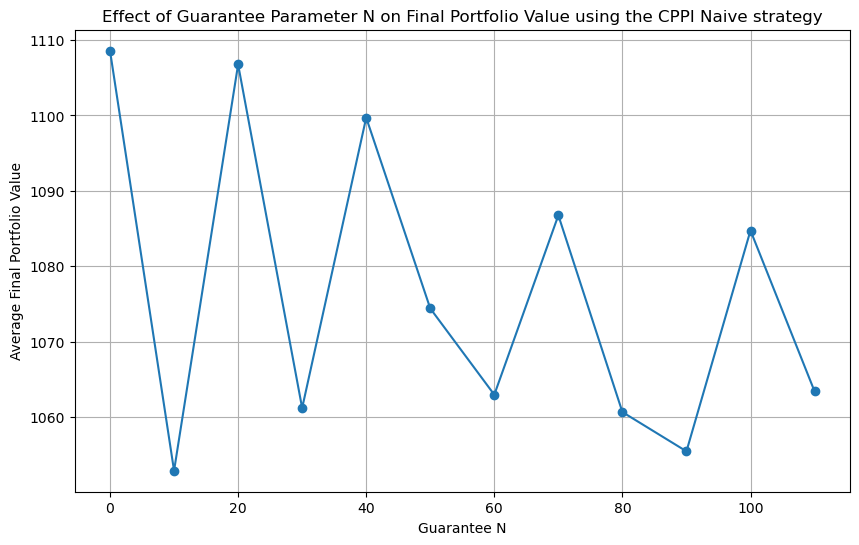

In [61]:
np.random.seed(99)

N_values = np.linspace(0, 110, 12)
n_simulations = 100
final_values = np.zeros(len(N_values))

for j, N in enumerate(N_values):
    simulation_results = []
    for i in range(n_simulations):
        t, risky_prices = simulate_gbm(S0, mu, sigma, T, dt)
        portfolio = simulate_cppi_naive(risky_prices, r, dt, initial_portfolio, T, N)
        simulation_results.append(portfolio[-1])
    final_values[j] = np.mean(simulation_results)

plt.figure(figsize=(10, 6))
plt.plot(N_values, final_values, marker='o', linestyle='-')
plt.xlabel('Guarantee N')
plt.ylabel('Average Final Portfolio Value')
plt.title('Effect of Guarantee Parameter N on Final Portfolio Value using the CPPI Naive strategy')
plt.grid(True)
plt.show()

## Simulation of the CPPI strategy

In [29]:
def simulate_cppi(risky_prices, riskfree_rate, m, dt, initial_portfolio, T, N):
    n = len(risky_prices)
    portfolio = np.zeros(n)
    portfolio[0] = initial_portfolio
    riskfree_growth = np.exp(riskfree_rate * dt) 

    for i in range(n - 1):
        t = i * dt
        floor = N * np.exp(-riskfree_rate * (T - t))
        
        if portfolio[i] < floor:
            portfolio[i+1] = portfolio[i] * riskfree_growth
        else:
            cushion = portfolio[i] - floor
            risky_allocation = m * cushion
            riskfree_allocation = portfolio[i] - risky_allocation
            risky_return = risky_prices[i+1] / risky_prices[i]
            portfolio[i+1] = risky_allocation * risky_return + riskfree_allocation * riskfree_growth

    return portfolio

### Parameters

In [31]:
n = 10
N = 900       # Guarantee (target) value at maturity (N) for the zero-coupon bond component

### GBM

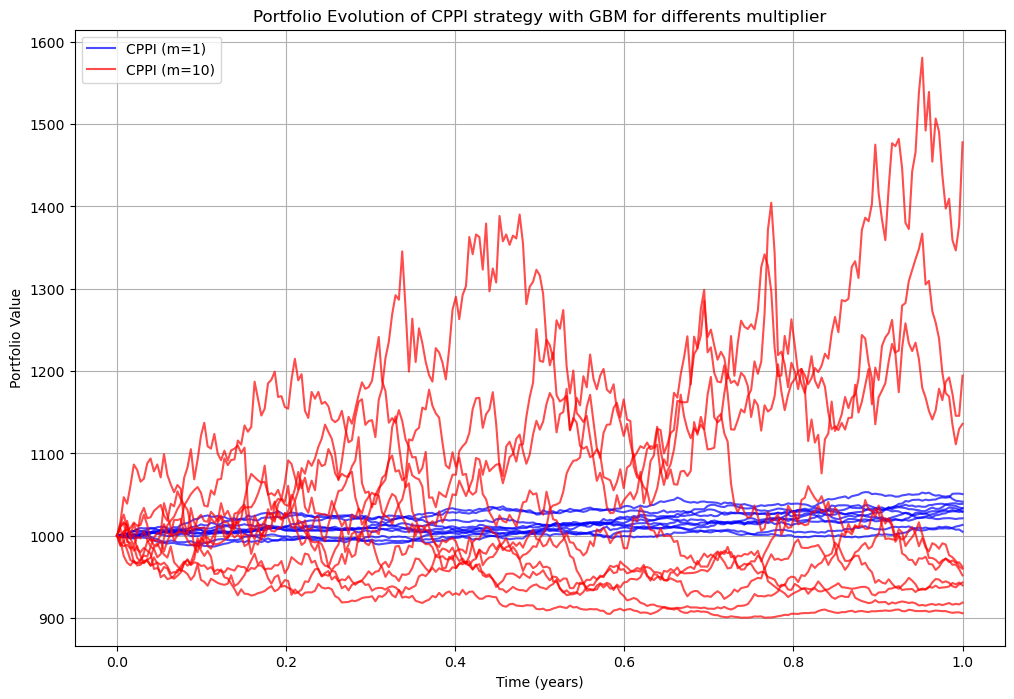

In [33]:
np.random.seed(49)

plt.figure(figsize=(12, 8))

for i in range(n):
    t, risky_prices = simulate_gbm(S0, mu, sigma, T, dt)
    portfolio = simulate_cppi(risky_prices, r, m=1, dt=dt, initial_portfolio=initial_portfolio, T=T, N=N)
    if i == 0:
        plt.plot(t, portfolio, color='blue', alpha=0.7, label="CPPI (m=1)")
    else:
        plt.plot(t, portfolio, color='blue', alpha=0.7)

for i in range(n):
    t, risky_prices = simulate_gbm(S0, mu, sigma, T, dt)
    portfolio = simulate_cppi(risky_prices, r, m=10, dt=dt, initial_portfolio=initial_portfolio, T=T, N=N)
    if i == 0:
        plt.plot(t, portfolio, color='red', alpha=0.7, label="CPPI (m=10)")
    else:
        plt.plot(t, portfolio, color='red', alpha=0.7)

plt.xlabel("Time (years)")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Evolution of CPPI strategy with GBM for differents multiplier")
plt.legend()
plt.grid(True)
plt.show()

### Jump Process

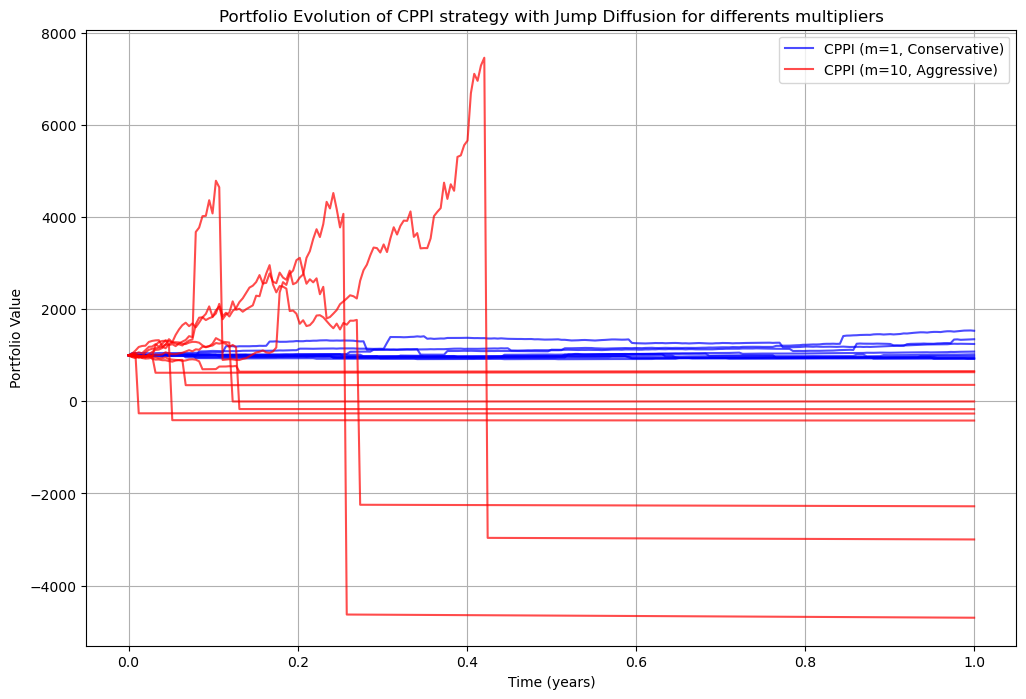

In [35]:
np.random.seed(1)

plt.figure(figsize=(12, 8))

for i in range(n):
    t, risky_prices = simulate_jump_diffusion(S0, mu, sigma, T, dt, lamb, jump_mu, jump_sigma)
    portfolio = simulate_cppi(risky_prices, r, m=1, dt=dt, initial_portfolio=initial_portfolio, T=T, N=N_conservative)
    if i == 0:
        plt.plot(t, portfolio, color='blue', alpha=0.7, label="CPPI (m=1, Conservative)")
    else:
        plt.plot(t, portfolio, color='blue', alpha=0.7)

for i in range(n):
    t, risky_prices = simulate_jump_diffusion(S0, mu, sigma, T, dt, lamb, jump_mu, jump_sigma)
    portfolio = simulate_cppi(risky_prices, r, m=10, dt=dt, initial_portfolio=initial_portfolio, T=T, N=N_aggressive)
    if i == 0:
        plt.plot(t, portfolio, color='red', alpha=0.7, label="CPPI (m=10, Aggressive)")
    else:
        plt.plot(t, portfolio, color='red', alpha=0.7)

plt.xlabel("Time (years)")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Evolution of CPPI strategy with Jump Diffusion for differents multipliers")
plt.legend()
plt.grid(True)
plt.show()

## Study of the multiplier and the floor parameters

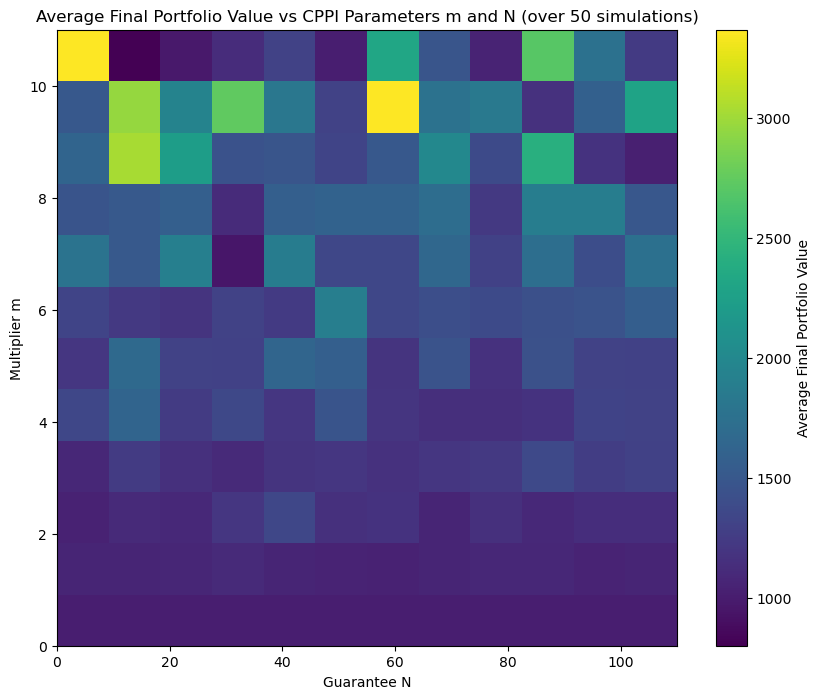

In [73]:
np.random.seed(99)

m_values = np.linspace(0, 11, 12)   
N_values = np.linspace(0, 110, 12)  
n_simulations = 50
final_values = np.zeros((len(m_values), len(N_values)))

for i, m in enumerate(m_values):
    for j, N in enumerate(N_values):
        simulation_results = []
        for k in range(n_simulations):
            t, risky_prices = simulate_gbm(S0, mu, sigma, T, dt)
            portfolio = simulate_cppi(risky_prices, r, m, dt, initial_portfolio, T, N)
            simulation_results.append(portfolio[-1])
        final_values[i, j] = np.mean(simulation_results)

plt.figure(figsize=(10, 8))
plt.imshow(final_values, extent=[N_values[0], N_values[-1], m_values[0], m_values[-1]], 
           aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Average Final Portfolio Value')
plt.xlabel('Guarantee N')
plt.ylabel('Multiplier m')
plt.title('Average Final Portfolio Value vs CPPI Parameters m and N (over {} simulations)'.format(n_simulations))
plt.show()

## Simulation of the Option-Based Portfolio Insurance (OBPI)

In [37]:
def call_option_price(S, K, r, tau, sigma):
    if tau <= 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)

def simulate_OBPI(risky_prices, riskfree_rate, T, dt, N, K, sigma):
    n = len(risky_prices)
    t_vec = np.linspace(0, T, n)
    OBPI = np.zeros(n)
    
    for i in range(n):
        t = t_vec[i]
        tau = T - t  
        P_t = N * np.exp(-riskfree_rate * tau)
        C_t = call_option_price(risky_prices[i], K, riskfree_rate, tau, sigma)
        OBPI[i] = P_t + C_t
        
    return t_vec, OBPI

### OBPI Parameters

In [39]:
N_OBPI = 900                       # Target guarantee (the bond matures to N at T)
K = 100                            # Strike price of the call option (commonly set to S0)
n = 10

### GBM

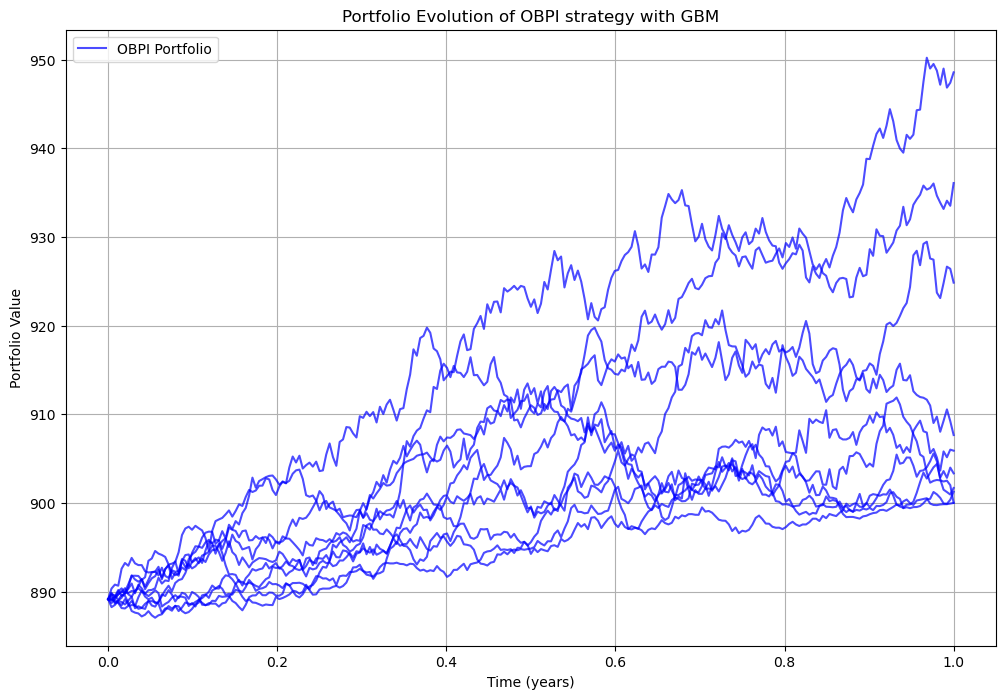

In [41]:
np.random.seed(90)

plt.figure(figsize=(12, 8))

for i in range(n):
    t, risky_prices = simulate_gbm(S0, mu, sigma, T, dt)
    t_vec, OBPI_value = simulate_OBPI(risky_prices, r, T, dt, N_OBPI, K, sigma)
    if i == 0:
        plt.plot(t_vec, OBPI_value, color='b', alpha=0.7, label="OBPI Portfolio")
    else:
        plt.plot(t_vec, OBPI_value, color='b', alpha=0.7)

plt.xlabel("Time (years)")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Evolution of OBPI strategy with GBM")
plt.legend()
plt.grid(True)
plt.show()

### Jump Process

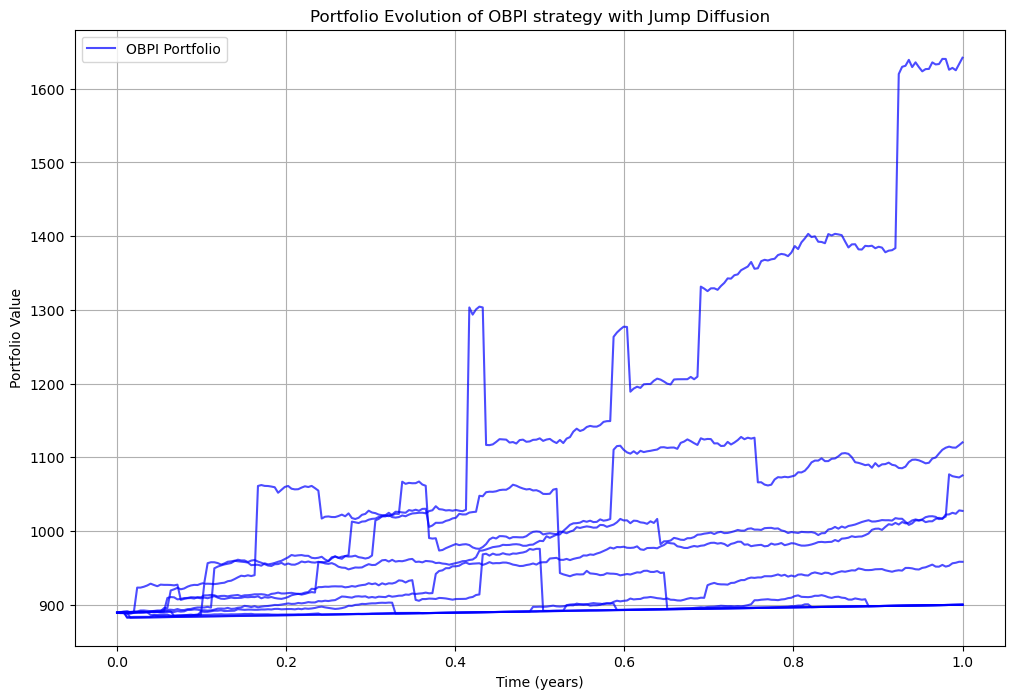

In [43]:
np.random.seed(49)

plt.figure(figsize=(12, 8))

for i in range(n):
    t, risky_prices = simulate_jump_diffusion(S0, mu, sigma, T, dt, lamb=10, jump_mu=-0.1, jump_sigma=0.3)
    t_vec, OBPI_value = simulate_OBPI(risky_prices, r, T, dt, N, K, sigma)
    if i == 0:
        plt.plot(t_vec, OBPI_value, color='b', alpha=0.7, label="OBPI Portfolio")
    else:
        plt.plot(t_vec, OBPI_value, color='b', alpha=0.7)

plt.xlabel("Time (years)")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Evolution of OBPI strategy with Jump Diffusion")
plt.legend()
plt.grid(True)
plt.show()

## Study of the strike price and the floor parameters

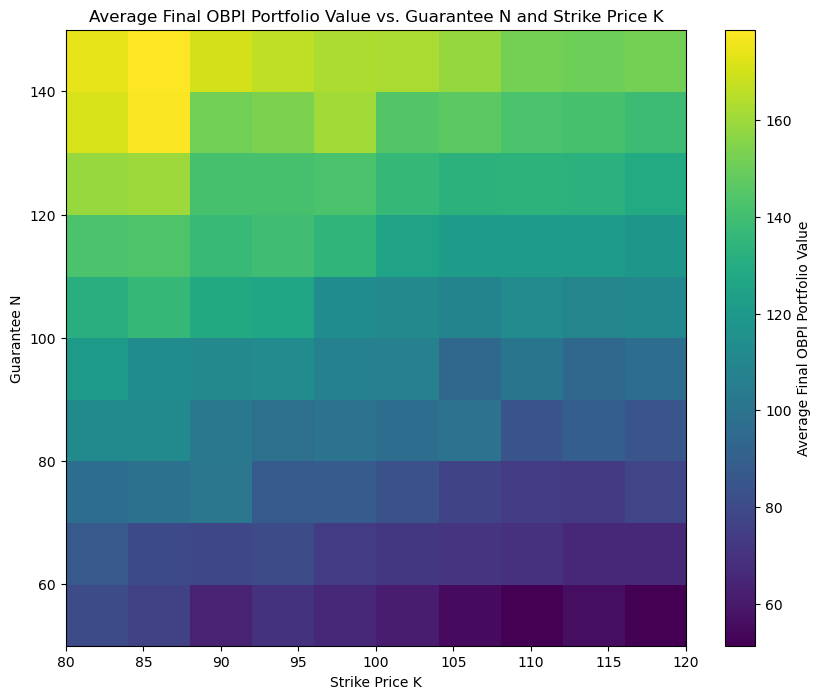

In [85]:
np.random.seed(100)

N_values = np.linspace(50, 150, 10)  
K_values = np.linspace(80, 120, 10)  
n_simulations = 10
final_values = np.zeros((len(N_values), len(K_values)))

for i, N in enumerate(N_values):
    for j, K in enumerate(K_values):
        simulation_results = []
        for sim in range(n_simulations):
            t, risky_prices = simulate_gbm(S0, mu, sigma, T, dt)
            t_vec, OBPI_values = simulate_OBPI(risky_prices, r, T, dt, N, K, sigma)
            simulation_results.append(OBPI_values[-1])
        final_values[i, j] = np.mean(simulation_results)
        
plt.figure(figsize=(10, 8))
plt.imshow(final_values, extent=[K_values[0], K_values[-1], N_values[0], N_values[-1]], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Average Final OBPI Portfolio Value')
plt.xlabel('Strike Price K')
plt.ylabel('Guarantee N')
plt.title('Average Final OBPI Portfolio Value vs. Guarantee N and Strike Price K')
plt.show()

## Simulation of the CPPI with a Dynamic Floor

In [45]:
def simulate_cppi_dynamic(risky_prices, riskfree_rate, m, dt, initial_portfolio, T, N, delta_param):
    n = len(risky_prices)
    portfolio = np.zeros(n)
    floor_values = np.zeros(n)
    cushions = np.zeros(n)
    
    portfolio[0] = initial_portfolio
    S0 = risky_prices[0] 

    for i in range(n):
        t = i * dt
        F_static = N * np.exp(-riskfree_rate * (T - t))
        Delta_t = delta_param * (1 - risky_prices[i] / S0)
        # Dynamic floor:
        F_t = F_static + Delta_t
        floor_values[i] = F_t
        # Cushion:
        cushions[i] = portfolio[i] - F_t
        
        if i == n - 1:
            break
        
        if portfolio[i] < F_t:
            # Floor breach: invest 100% in the risk-free asset
            portfolio[i+1] = portfolio[i] * np.exp(riskfree_rate * dt)
        else:
            cushion = portfolio[i] - F_t
            exposure = m * cushion
            # Cap the risky allocation by the total portfolio value
            risky_allocation = exposure
            riskfree_allocation = portfolio[i] - risky_allocation
            risky_return = risky_prices[i+1] / risky_prices[i]
            portfolio[i+1] = risky_allocation * risky_return + riskfree_allocation * np.exp(riskfree_rate * dt)
    
    return portfolio, floor_values, cushions

### Dynamic floor parameters

In [49]:
m = 3                       # CPPI multiplier
N = 900                     # Nominal value (target guarantee at maturity)
delta_param = 50            # Parameter for dynamic floor adjustment

### GBM

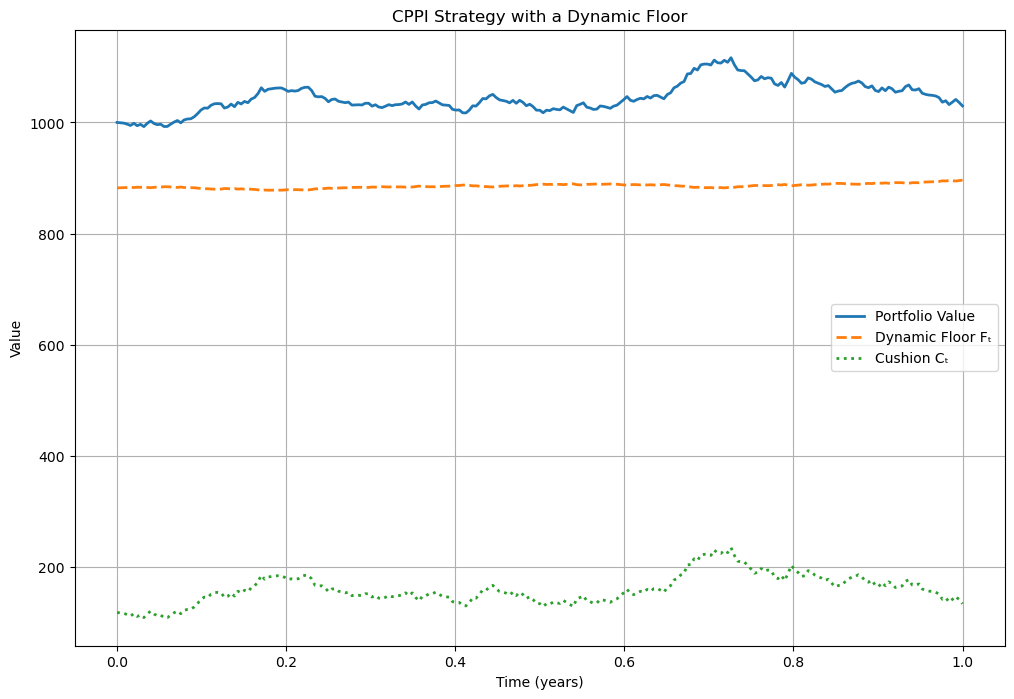

In [51]:
np.random.seed(90)

t, risky_prices = simulate_gbm(S0, mu, sigma, T, dt)
portfolio, floor_values, cushions = simulate_cppi_dynamic(risky_prices, r, m, dt, initial_portfolio, T, N, delta_param)

plt.figure(figsize=(12, 8))
plt.plot(t, portfolio, lw=2, label="Portfolio Value")
plt.plot(t, floor_values, lw=2, linestyle="--", label="Dynamic Floor Fₜ")
plt.plot(t, cushions, lw=2, linestyle=":", label="Cushion Cₜ")
plt.xlabel("Time (years)")
plt.ylabel("Value")
plt.title("CPPI Strategy with a Dynamic Floor")
plt.legend()
plt.grid(True)
plt.show()

### Jump Process

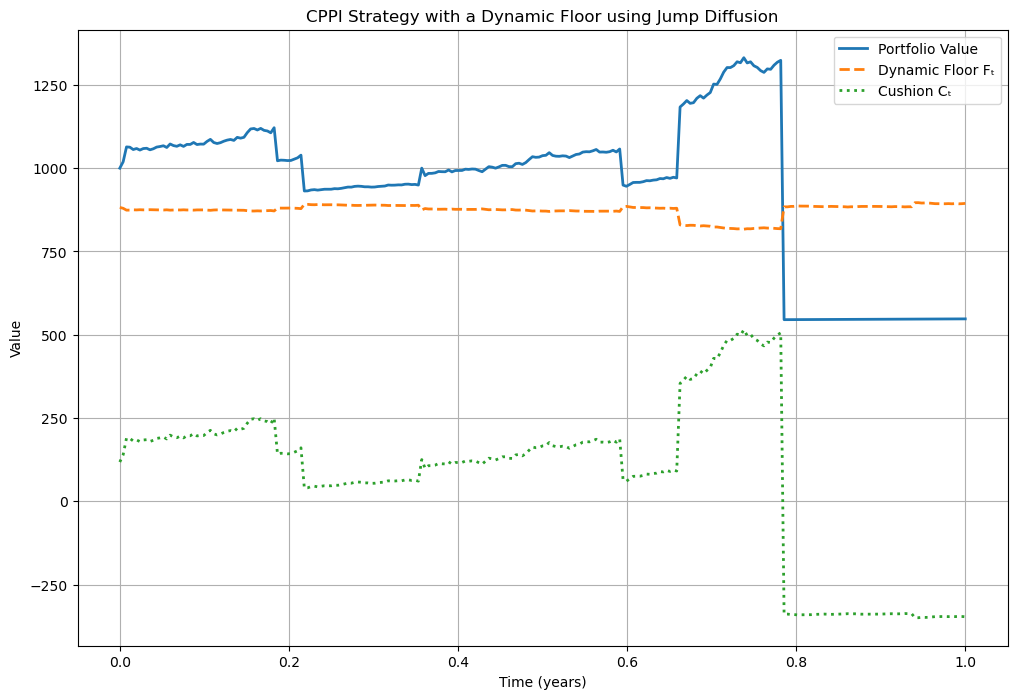

In [53]:
np.random.seed(4)

# Simulate a risky asset path using the jump diffusion model
t, risky_prices = simulate_jump_diffusion(S0, mu, sigma, T, dt, lamb, jump_mu, jump_sigma)

# Simulate the CPPI strategy with a dynamic floor using the jump diffusion prices
portfolio, floor_values, cushions = simulate_cppi_dynamic(risky_prices, r, m, dt, initial_portfolio, T, N, delta_param)

plt.figure(figsize=(12, 8))
plt.plot(t, portfolio, lw=2, label="Portfolio Value")
plt.plot(t, floor_values, lw=2, linestyle="--", label="Dynamic Floor Fₜ")
plt.plot(t, cushions, lw=2, linestyle=":", label="Cushion Cₜ")
plt.xlabel("Time (years)")
plt.ylabel("Value")
plt.title("CPPI Strategy with a Dynamic Floor using Jump Diffusion")
plt.legend()
plt.grid(True)
plt.show()

## Study of the multiplier and the floor parameters

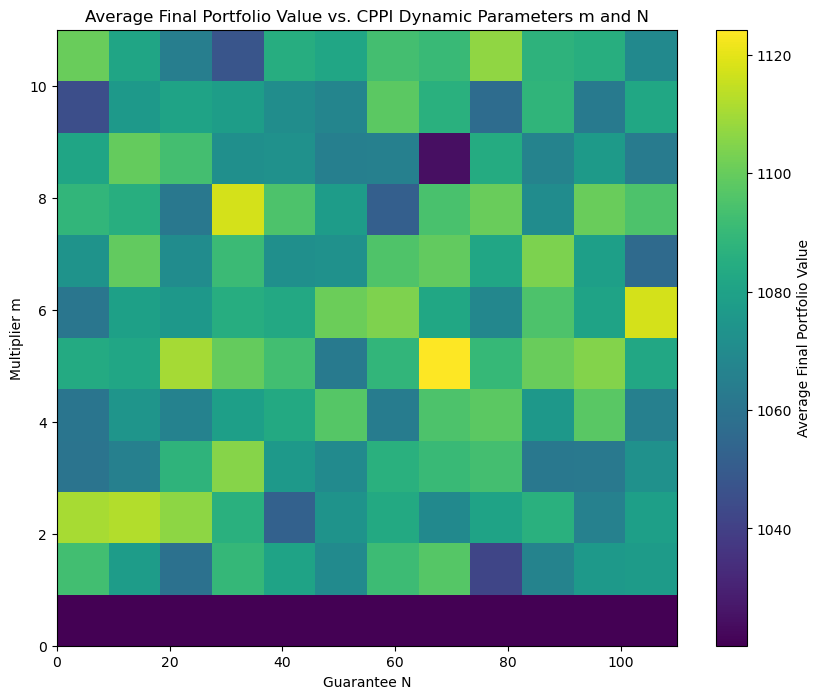

In [95]:
np.random.seed(100)

m_values = np.linspace(0, 11, 12) 
N_values = np.linspace(0, 110, 12) 

# Fixed delta parameter for the dynamic adjustment term in the floor
delta_param = 10 
n_simulations = 100
final_values = np.zeros((len(m_values), len(N_values)))

for i, m in enumerate(m_values):
    for j, N in enumerate(N_values):
        simulation_results = []
        for sim in range(n_simulations):
            t, risky_prices = simulate_gbm(S0, mu, sigma, T, dt)
            portfolio, floor_values, cushions = simulate_cppi_dynamic(risky_prices, r, m, dt, initial_portfolio, T, N, delta_param)
            simulation_results.append(portfolio[-1])
        final_values[i, j] = np.mean(simulation_results)

plt.figure(figsize=(10, 8))
plt.imshow(final_values, extent=[N_values[0], N_values[-1], m_values[0], m_values[-1]], 
           aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Average Final Portfolio Value')
plt.xlabel('Guarantee N')
plt.ylabel('Multiplier m')
plt.title('Average Final Portfolio Value vs. CPPI Dynamic Parameters m and N')
plt.show()

## Simulation using Real Data (yfinance)

In [55]:
S0 = 1000                     # Initial price of the risky asset
mu = 0.08                     # Expected annual return (drift) of the risky asset
sigma = 0.15                  # Annual volatility of the risky asset
T = 1.0                       # Total investment horizon in years
dt = 1/252                    # Time step in years (assuming 252 trading days per year)
initial_portfolio = 1000      # Initial capital
r = 0.02                      # Risk-free rate (2% per annum)
m = 5                         # Increased multiplier to amplify exposure to risk
N = 70                        # Lowered target guarantee (for an initial portfolio of 100)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


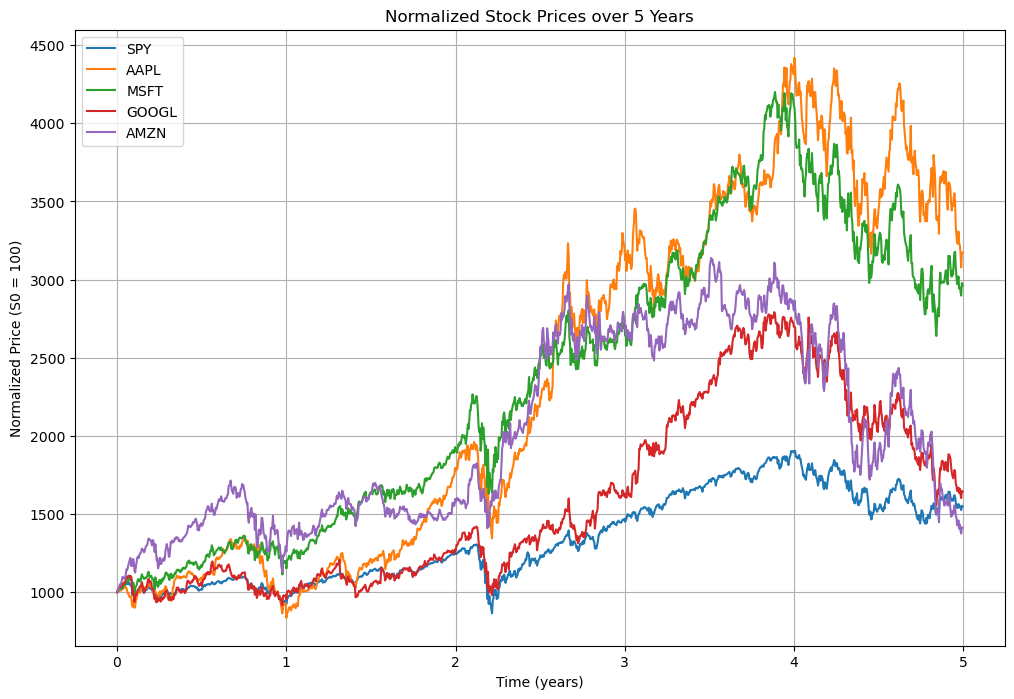

In [57]:
# List of tickers for 5 stocks
tickers = ["SPY", "AAPL", "MSFT", "GOOGL", "AMZN"]

# Date range for the data (5 years)
start_date = "2018-01-01"
end_date = "2023-01-01"

# Download and store data once in a dictionary
data_dict = {}
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    # Use adjusted closing price and drop missing values
    adj_close = data['Adj Close'].dropna()
    # Normalize the price series to start at S0 = 100
    data_norm = adj_close / adj_close.iloc[0] * S0
    data_dict[ticker] = data_norm

plt.figure(figsize=(12, 8))

for ticker in tickers:
    series = data_dict[ticker]
    n = len(series)
    t_real = np.linspace(0, n / 252, n)
    plt.plot(t_real, series.values, label=ticker)

plt.xlabel("Time (years)")
plt.ylabel("Normalized Price (S0 = 100)")
plt.title("Normalized Stock Prices over 5 Years")
plt.legend()
plt.grid(True)
plt.show()

## CPPI with no multiplier real

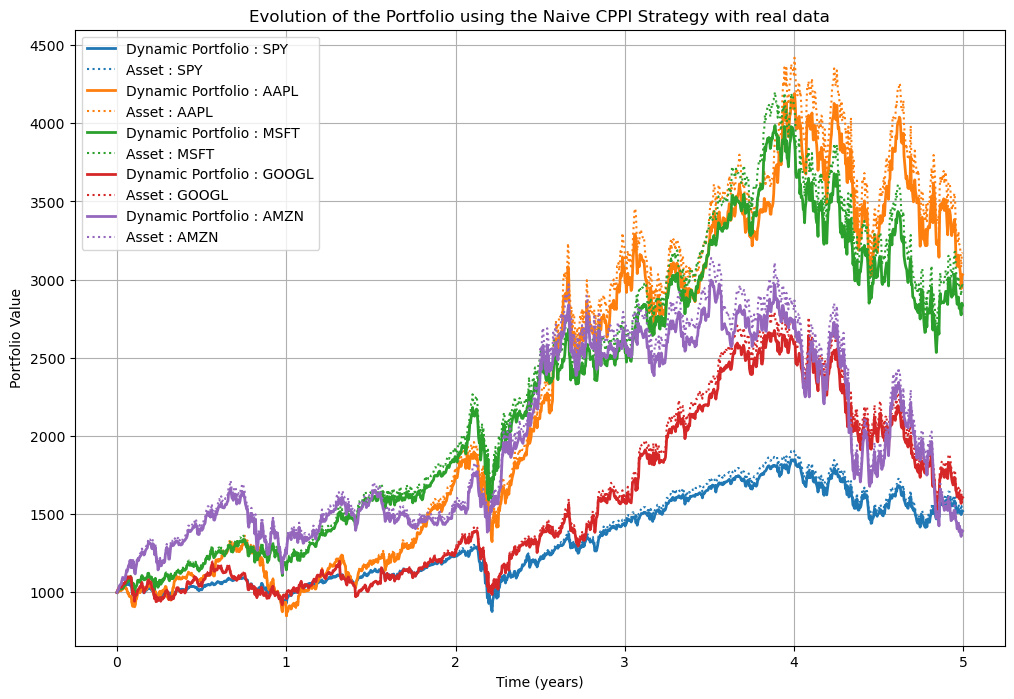

In [59]:
plt.figure(figsize=(12, 8))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for idx, ticker in enumerate(data_dict):
    series = data_dict[ticker] 
    n = len(series)
    t_vec = np.linspace(0, n/252, n)
    color = colors[idx % len(colors)]
    
    portfolio = simulate_cppi_naive(series.values, r, dt, initial_portfolio, T, N)
    
    plt.plot(t_vec, portfolio, lw=2, color=color, label=f"Dynamic Portfolio : {ticker}")
    plt.plot(t_vec, series.values, linestyle=":", lw=1.5, color=color, label=f"Asset : {ticker}")

plt.xlabel("Time (years)")
plt.ylabel("Portfolio Value")
plt.title("Evolution of the Portfolio using the Naive CPPI Strategy with real data")
plt.legend()
plt.grid(True)
plt.show()

## Simulation of the CPPI strategy

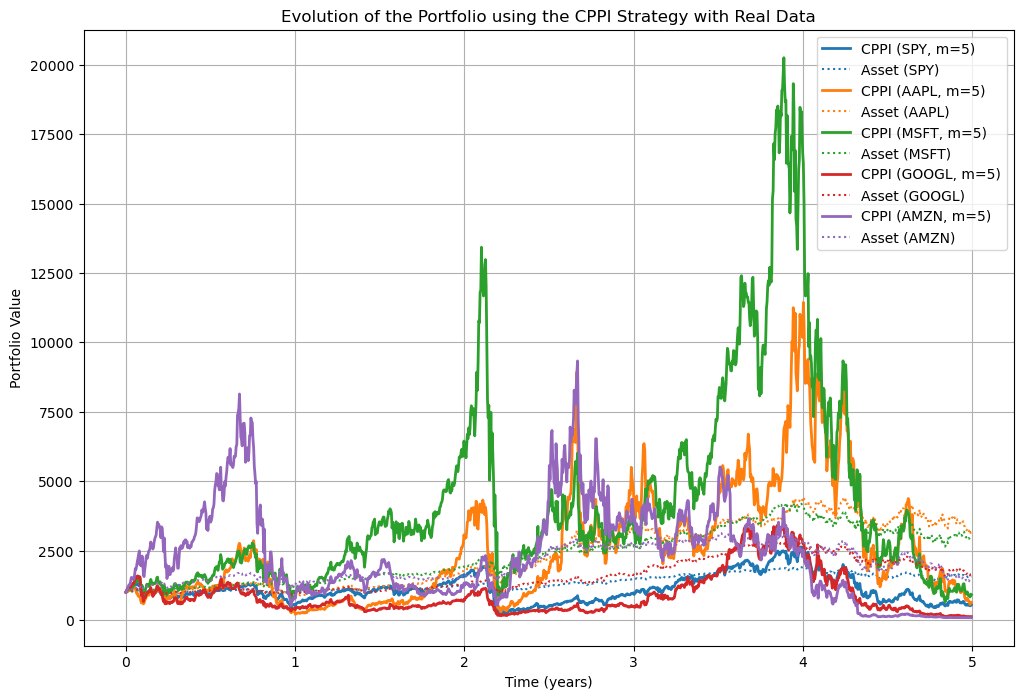

In [103]:
plt.figure(figsize=(12, 8))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for idx, ticker in enumerate(data_dict):
    series = data_dict[ticker]
    n = len(series)
    t_vec = np.linspace(0, n/252, n)
    color = colors[idx % len(colors)]
    
    portfolio = simulate_cppi(series.values, r, m, dt, initial_portfolio, T, N)
    
    plt.plot(t_vec, portfolio, lw=2, color=color, label=f"CPPI ({ticker}, m={m})")
    plt.plot(t_vec, series.values, linestyle=":", lw=1.5, color=color, label=f"Asset ({ticker})")

plt.xlabel("Time (years)")
plt.ylabel("Portfolio Value")
plt.title("Evolution of the Portfolio using the CPPI Strategy with Real Data")
plt.legend()
plt.grid(True)
plt.show()

## Simulation of the Option-Based Portfolio Insurance (OBPI)

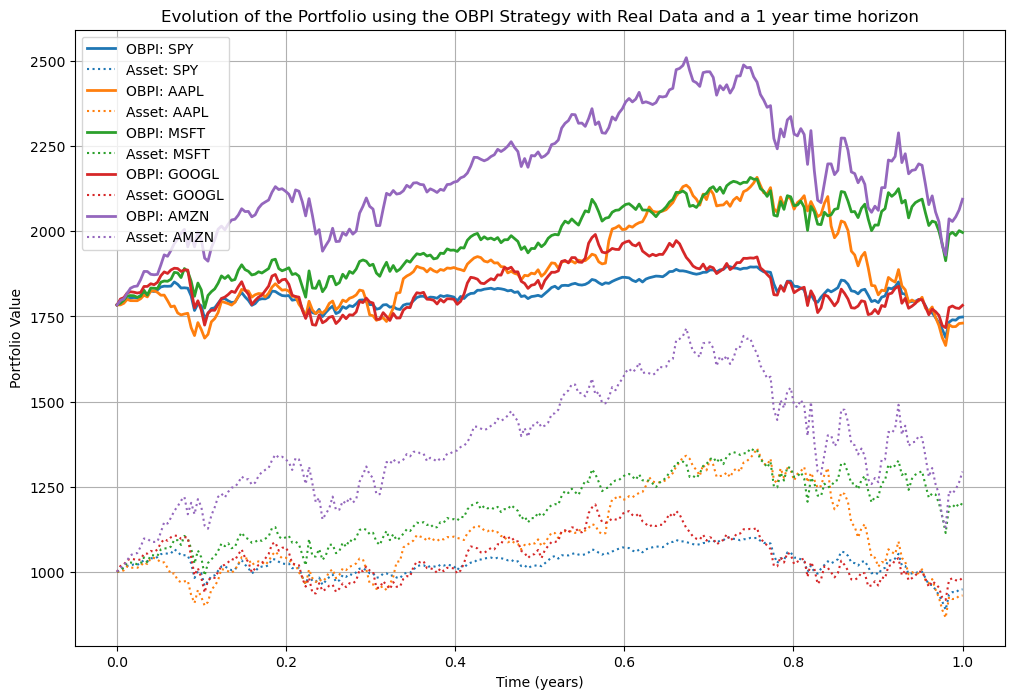

In [131]:
plt.figure(figsize=(12, 8))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for idx, ticker in enumerate(data_dict):
    series = data_dict[ticker]
    if len(series) < 252:
        continue  # Skip if not enough data
    series_1yr = series.values[:252]
    t_vec = np.linspace(0, 1, len(series_1yr))
    
    color = colors[idx % len(colors)]
    
    t_OBPI, OBPI_values = simulate_OBPI(series_1yr, r, T, dt, N_OBPI, K, sigma)
    
    plt.plot(t_OBPI, OBPI_values, lw=2, color=color, label=f"OBPI: {ticker}")
    plt.plot(t_OBPI, series_1yr, linestyle=":", lw=1.5, color=color, label=f"Asset: {ticker}")

plt.xlabel("Time (years)")
plt.ylabel("Portfolio Value")
plt.title("Evolution of the Portfolio using the OBPI Strategy with Real Data and a 1 year time horizon")
plt.legend()
plt.grid(True)
plt.show()

## Simulation of the CPPI with a Dynamic Floor

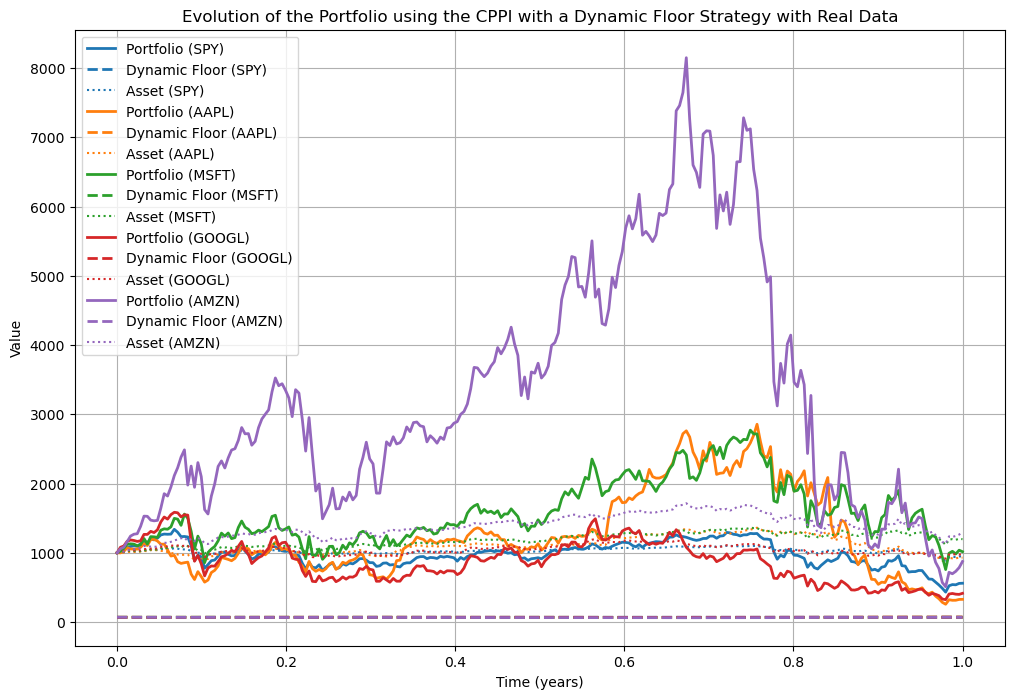

In [133]:
plt.figure(figsize=(12, 8))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for idx, ticker in enumerate(data_dict):
    series = data_dict[ticker]
    if len(series) < 252:
        continue
    series_1yr = series.values[:252]
    t_vec = np.linspace(0, 1, len(series_1yr))
    
    color = colors[idx % len(colors)]
    
    portfolio, floor_values, cushions = simulate_cppi_dynamic(
        series_1yr, r, m, dt, initial_portfolio, T, N, delta_param
    )
    
    plt.plot(t_vec, portfolio, lw=2, color=color, label=f"Portfolio ({ticker})")
    plt.plot(t_vec, floor_values, lw=2, linestyle="--", color=color, label=f"Dynamic Floor ({ticker})")
    plt.plot(t_vec, series_1yr, lw=1.5, linestyle=":", color=color, label=f"Asset ({ticker})")

plt.xlabel("Time (years)")
plt.ylabel("Value")
plt.title("Evolution of the Portfolio using the CPPI with a Dynamic Floor Strategy with Real Data")
plt.legend()
plt.grid(True)
plt.show()